In [47]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchsummary import summary
from PIL import Image
import random
import pandas as pd
import torch
import os
import shutil
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [49]:
from scipy.linalg import sqrtm
import numpy as np
import torchvision.models as models

In [50]:
folder_path = './image_data/ResizedImages/'

In [51]:
checkpoint_path = os.path.join(folder_path, '.ipynb_checkpoints')
if os.path.exists(checkpoint_path):
    shutil.rmtree(checkpoint_path)

In [52]:
# Check the dimensions of all images and identify those that are not 28x28
non_28x28_images = {}

for image_name in os.listdir(folder_path):
    if os.path.isdir(folder_path):
        continue
    with Image.open(os.path.join(folder_path, image_name)) as img:
        if img.size != (28, 28):
            non_28x28_images[image_name] = img.size

non_28x28_images

{}

In [53]:
# Transformations for your dataset
transform = transforms.Compose([
                                transforms.Grayscale(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
])

# Assuming that all images are in 'ResizedImages/data/' directory
data_directory = "./image_data/"
trainset = datasets.ImageFolder(data_directory, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

In [54]:
data_iter = iter(trainloader)
images, labels = next(data_iter)
images.shape

torch.Size([128, 1, 28, 28])

In [72]:
# device = torch.device('cpu')
# device = torch.device('mps')
# The model was trained on a Macintosh system, that has Metal Performance Shaders (MPS), which is a dedicated SoC GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Discriminator

In [73]:
def weights_init(m):
    # We need this function to initialize weights, with normal initialization, so the 
    # model trains properly
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [74]:
def disc_conv(in_c, out_c, ks=4, stride=2, padding=1, bn=True, out_layer=False):
    layers = [nn.Conv2d(in_c, out_c, kernel_size=ks, stride=stride, padding=padding, bias=False)]
    if bn: layers.append(nn.BatchNorm2d(out_c))
    layers.append(nn.Sigmoid() if out_layer else nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)

In [75]:
D = nn.Sequential(
    disc_conv(1, 32, bn=False),
    disc_conv(32, 64),
    disc_conv(64, 128, ks=3),
    disc_conv(128, 1, out_layer=True, bn=False, padding=0)
)
D
# our discriminator is a fully convolutional network, it decides wheter image is real or fake

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (3): Sequential(
    (0): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): Sigmoid()
  )
)

# Generator

In [76]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(*[
                                      self.conv_block(100, 128, padding=0),
                                      self.conv_block(128, 64, stride=2, ks=3),
                                      self.conv_block(64, 32, stride=2),
                                      self.conv_block(32, 1, stride=2, bn=False, out_layer=True)
        ])
    # Our input is 100 dimensional random noise

    @staticmethod
    def conv_block(in_c, out_c, out_layer=False, ks=4, stride=1, padding=1, bias=False, bn=True):
        l = [nn.ConvTranspose2d(in_c, out_c, ks, stride=stride, padding=padding, bias=bias)]
        if bn: l.append(nn.BatchNorm2d(out_c))
        if out_layer: l.append(nn.Tanh())
        else: l.append(nn.ReLU(True))
        return nn.Sequential(*l)

    def forward(self, x):
        return self.layers(x)

In [77]:
G = Generator()
G

Generator(
  (layers): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Tanh()
    )
  )
)

In [78]:
fixed_noise = torch.rand((64, 100, 1, 1))
G.apply(weights_init)
D.apply(weights_init)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (3): Sequential(
    (0): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): Sigmoid()
  )
)

In [79]:
criterion = nn.BCELoss()
criterion = criterion.to(device)

In [80]:
optim_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [81]:
D = D.to(device)
G = G.to(device)

In [82]:
EPOCHS = 100
FAKE_LABEL = 0.0 # 0.0
REAL_LABEL = 1.0 # 1.0

# Training

In [ ]:
G_losses = []
D_losses = []
D_update_frequency = 1
G_update_frequency = 2

for epoch in range(1, EPOCHS + 1):
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        fake_labels = torch.full((images.size(0), ), FAKE_LABEL).to(device)
        real_labels = torch.full((images.size(0), ), REAL_LABEL).to(device)

        # Train Discriminator
        if i % D_update_frequency == 0:
            D.zero_grad()
            d_real = D(images).view(-1)
            d_loss_real = criterion(d_real, real_labels)
            d_loss_real.backward()

            noise = torch.randn((images.size(0), 100, 1, 1)).to(device)
            fake_images = G(noise)
            d_fake = D(fake_images.detach()).view(-1)
            d_loss_fake = criterion(d_fake, fake_labels)
            d_loss_fake.backward()

            d_loss = d_loss_real + d_loss_fake
            optim_D.step()

        # Train Generator
        for _ in range(G_update_frequency):
            G.zero_grad()
            noise = torch.randn((images.size(0), 100, 1, 1)).to(device)
            fake_images = G(noise)
            d_fake = D(fake_images).view(-1)
            g_loss = criterion(d_fake, real_labels)
            g_loss.backward()
            optim_G.step()
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{EPOCHS}], Batch [{i}], LOSS_D: {d_loss}, LOSS_G: {g_loss}")


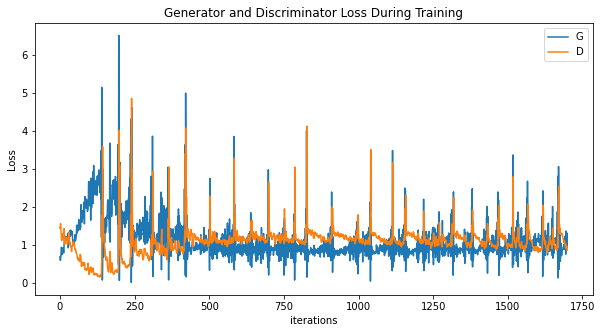

In [23]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [24]:
pd.DataFrame([G_losses, D_losses]).to_csv('G_D_losses_1.csv')

In [25]:
from torchsummary import summary

latent_vector_size = 100

G = G.to('cpu')

summary(G, input_size=(latent_vector_size, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 128, 4, 4]         204,800
       BatchNorm2d-2            [-1, 128, 4, 4]             256
              ReLU-3            [-1, 128, 4, 4]               0
   ConvTranspose2d-4             [-1, 64, 7, 7]          73,728
       BatchNorm2d-5             [-1, 64, 7, 7]             128
              ReLU-6             [-1, 64, 7, 7]               0
   ConvTranspose2d-7           [-1, 32, 14, 14]          32,768
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]             512
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 312,256
Trainable params: 312,256
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

# Generated Images

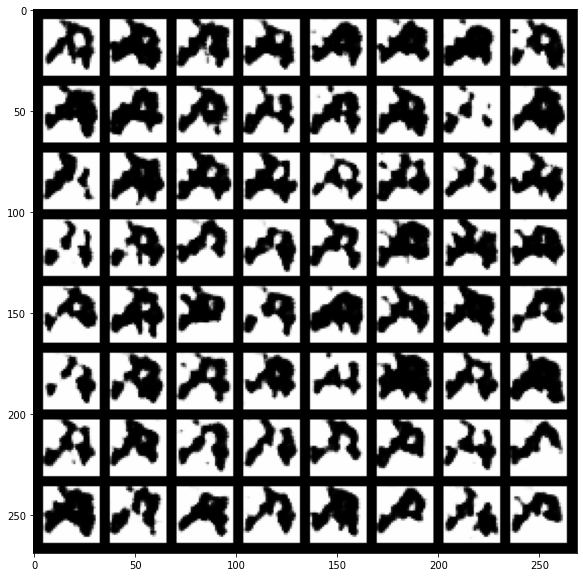

In [26]:
fig = plt.figure(figsize=(10, 10))
rand_noise = torch.rand((64, 100, 1, 1))
with torch.no_grad():
    out = vutils.make_grid(G(rand_noise).cpu(), padding=5, normalize=True)
plt.imshow(np.transpose(out.numpy(), (1, 2, 0)), cmap="gray")


# Calculating FID Score

In [28]:
# Generate a batch of random noise vectors
noise = torch.randn(64, 100, 1, 1).cpu()

# Generate images using the trained generator
with torch.no_grad():
    generated_images = G(noise).cpu()

In [30]:
inception_model = models.inception_v3(pretrained=True).cpu().eval()

def calculate_fid(real_images, generated_images, model):
    real_features = get_features(real_images, model)
    generated_features = get_features(generated_images, model)
    
    # Compute mean and covariance
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)
    
    # Compute FID
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def get_features(images, model):
    images = images.cpu().float()  # Ensure images are on CPU in float format
    model = model.cpu().float()    # Ensure model is on CPU in float format

    # Resize images to match the Inception's input shape
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    
    # Replicate the grayscale image across 3 channels
    images = images.repeat(1, 3, 1, 1)
    
    # Get features from the Inception model
    with torch.no_grad():
        features = model(images).detach().cpu().numpy()
    return features


In [31]:
# Assuming you have a dataloader named `dataloader`
data_iter = iter(trainloader)
real_images, _ = next(data_iter)

In [32]:
real_features = get_features(real_images, inception_model)
generated_features = get_features(generated_images, inception_model)


In [33]:
# Compute mean and covariance
mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
mu2, sigma2 = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)

In [34]:
# Compute FID
ssdiff = np.sum((mu1 - mu2)**2.0)
covmean = sqrtm(sigma1.dot(sigma2))
if np.iscomplexobj(covmean):
    covmean = covmean.real
fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
print("FID score:", fid)

FID score: 812.3714279873412
